In [1]:
import pandas as pd
import numpy as np
import time
from time import perf_counter
n = 192
cid = 167
geoid = 1

# read data
df_full_20 = pd.read_pickle(r'df_full_geo_metrics_20region.pkl')[['pos','sku','normalized_cvr_scores', 'normalized_scores','clid','geo','sample']]
df_full_20 = df_full_20.loc[(df_full_20['clid'] == cid) & (df_full_20['geo'] == str(geoid)) & (df_full_20['sample'] == 1)]
df_full_20_bb = df_full_20[:n]
#print(df_full_20_bb.describe())
#print(df_full_20_bb.head())
df_full_20_geo = df_full_20[n:]


In [2]:
# get normalized impression weights 
imp = pd.read_pickle(r'df_visits_04_05_2022.pkl').sort_values(by='pos', ascending=True)
imp = imp.loc[(imp['clid'] == cid) & (imp['geo'] == geoid)]
new_col = 'normalized_impressions'
col = 'impressions'
imp[new_col] = (imp[col] - imp[col].min()+0.0001) / (imp[col].max() - imp[col].min())  
#print(imp.head())
impre = imp.set_index('pos').to_dict()['normalized_impressions']
#print(impre)

In [3]:
# get impression weighted sum of rcts and cvr for bubble sort
cvr_bbsort = df_full_20_bb.set_index('pos').to_dict()['normalized_cvr_scores']
#print(cvr_bbsort)
rcts_bbsort =  df_full_20_bb.set_index('pos').to_dict()['normalized_scores']
imp_weighted_rcts_by_bbsort = sum([rcts_bbsort[i]*impre[i] for i in range(1,n+1)]) 
imp_weighted_cvr_by_bbsort  = sum([cvr_bbsort[i]*impre[i] for i in range(1,n+1)])
print("imp_weighted_rcts_by_bbsort",imp_weighted_rcts_by_bbsort)
print("imp_weighted_cvr_by_bbsort", imp_weighted_cvr_by_bbsort)



imp_weighted_rcts_by_bbsort 27.751950497856992
imp_weighted_cvr_by_bbsort 37.856116439846176


In [4]:
# get impression weighted sum of rcts and cvr for  geo sort
cvr_geosort = df_full_20_geo.set_index('pos').to_dict()['normalized_cvr_scores']
rcts_geosort =  df_full_20_geo.set_index('pos').to_dict()['normalized_scores']
imp_weighted_rcts_by_geosort = sum([rcts_geosort[i]*impre[i] for i in range(1,n+1)]) 
imp_weighted_cvr_by_geosort  = sum([cvr_geosort[i]*impre[i] for i in range(1,n+1)])
print("imp_weighted_rcts_by_geosort",imp_weighted_rcts_by_geosort)
print("imp_weighted_cvr_by_geosort", imp_weighted_cvr_by_geosort)


imp_weighted_rcts_by_geosort 16.37039787872306
imp_weighted_cvr_by_geosort 36.197236007118505


In [5]:
{
    "tags": [
        "hide-output"
    ]
}

from pyomo.environ import *
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# solve optimization model for customized conversion rate threshold and add the result to pareto front
def opt_rank(cvr_thold,pareto):
    model = ConcreteModel()
    #Index Set I J, I for products, J for position
    model.I = Set(initialize = df_full_20_bb['sku'].tolist())
    model.J = Set(initialize = imp['pos'].tolist())

    # Parameter:  cvr for ith product's CVR, rcts for ith product's RCTS, alpha for jth position's impression weight
    model.cvr = Param(model.I,initialize=cvr)
    model.rcts = Param(model.I,initialize=rcts)
    model.impre = Param(model.J, initialize=impre)

    # Var: zij, whether place product i at position j
    model.z = Var(model.I, model.J, within= Binary)

    # Objective: minimize total RCTS regarding products and positions
    def obj_rule(model):
        return sum(sum(model.z[i,j]*model.rcts[i] for i in model.I)
                   * model.impre[j]
                   for j in model.J)
    model.obj = Objective(rule = obj_rule, sense=minimize)


    #Constraints
        #c1: cvr sum above C

    def c1_rule(model):
        return sum(sum(model.z[i,j]*model.cvr[i] for i in model.I)
                   * model.impre[j]
                   for j in model.J) >= cvr_thold # 1 as default, set to other threshold later
    model.c1 = Constraint(rule = c1_rule)
        #c2: each position only 1 product

    def c2_rule(model, j):
        return sum([model.z[i,j] for i in model.I]) == 1
    model.c2 = Constraint(model.J, rule = c2_rule)

    def c3_rule(model, i):
        return sum([model.z[i,j] for j in model.J]) == 1
    model.c3 = Constraint(model.I, rule = c3_rule)

    model.write('model.lp') # output model file

    #model.pprint() #  print model info

    solver = SolverFactory('gurobi') # set gurobi as solver
    #solver.options["OptimalityTol"] = 0.01
    #solver.options["MIPGap"] = 0.01
    #solver.options["Threads"] = 96
    #solver.options["Presolve"] = 1
    #solver.options["TimeLimit"] = 100

    solution = solver.solve(model,tee = False) # solve 
    solution.write() # write solution result


    x_opt = np.array([value(model.z[i,j]) for i in model.I for j in model.J]).reshape((len(model.I), len(model.J))) # 提取最优解
    obj_values = value(model.obj) # Extract the objective function at the optimal point
    #print("optimal objective: \n {}".format(obj_values))

    c1_val = np.dot(np.dot(list(cvr.values()), x_opt),list(impre.values()) )
    pareto.append((c1_val,obj_values))
    #print("c1_val at optimal objective:  {}".format(c1_val))
    #print("c1_threshold: {}".format(cvr_thold))

In [6]:
# get input data for optimization
cvr = df_full_20_bb.set_index('sku').to_dict()['normalized_cvr_scores']
rcts =  df_full_20_bb.set_index('sku').to_dict()['normalized_scores']

alpha = np.linspace(0.5,1,50)
cvr_tholds = [i * imp_weighted_cvr_by_bbsort for i in alpha]
pareto = []
for cvr_thold in cvr_tholds:
    opt_rank(cvr_thold,pareto)

#print("optimum point: \n {} ".format(x_opt))
#print("x_opt.shape",(x_opt.shape))

#from numpy import savetxt
#savetxt('./x_opt_alpha'+str(alpha)+'_n'+str(n)+'_cl'+str(cid)+'_geo'+str(geoid)+'.csv', x_opt, delimiter=',')

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x36865
  Lower bound: 16.060822101799168
  Upper bound: 16.060822101799168
  Number of objectives: 1
  Number of constraints: 386
  Number of variables: 36865
  Number of binary variables: 36864
  Number of integer variables: 36864
  Number of continuous variables: 1
  Number of nonzeros: 110593
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination me

In [7]:
print(pareto)

[(35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917), (35.18095203480101, 16.06082210179917),

/tmp/ipykernel_71214/3508107488.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_val,y_val,'or',color="blue")


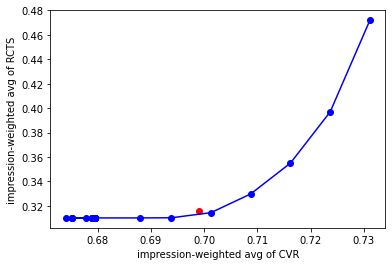

In [27]:
from matplotlib import pyplot as plt
x_val = [x[0]/np.sum(imp['normalized_impressions']) for x in pareto]
y_val = [x[1]/np.sum(imp['normalized_impressions']) for x in pareto]
plt.plot(x_val,y_val,c = "blue")
plt.plot(x_val,y_val,'or',color="blue")
plt.xlabel("impression-weighted avg of CVR")
plt.ylabel("impression-weighted avg of RCTS")
plt.scatter(imp_weighted_cvr_by_geosort/np.sum(imp['normalized_impressions']),imp_weighted_rcts_by_geosort/np.sum(imp['normalized_impressions']),c= "red")
plt.show()

In [30]:
print("acc time", end-start)
print("imp_weighted_rcts_by_bbsort",imp_weighted_rcts_by_bbsort)
print("imp_weighted_cvr_by_bbsort", imp_weighted_cvr_by_bbsort)
print("imp_weighted_rcts_by_geosort",imp_weighted_rcts_by_geosort)
print("imp_weighted_cvr_by_geosort", imp_weighted_cvr_by_geosort)
print("imp_weighted_rcts_by_optrank:  {}".format(obj_values))
print("imp_weighted_cvr_by_optrank:  {}".format(c1_val))

acc time till solving finished 5.280131246894598
imp_weighted_rcts_by_bbsort 27.751950497856992
imp_weighted_cvr_by_bbsort 37.856116439846176
imp_weighted_rcts_by_geosort 0.0852624889516826
imp_weighted_cvr_by_geosort 0.18852727087040888
imp_weighted_rcts_by_optrank:  16.334227604527825
imp_weighted_cvr_by_optrank:  36.341877173545555
